Tutorial 2: Brightness Adaption
===============================

In the previous tutorial we motivated our need to adapt the pixelization to the source's morphology, such that source
pixels congregates in the source's brightest regions regardless of where the source is located in the source-plane. This
raises an interesting question; how do we adapt our pixelization to the reconstructed source's light, before we've
actually reconstructed the source and therefore know what to adapt it too?

To do this, we define 'hyper_images' of the lensed source galaxy. A hyper image is a model image of the source computed
using a previous lens model that has been fit to the image (e.g. in the earlier search of a pipeline). This image tells
us where in the image our source is located, thus informing us of where we need to adapt our source pixelization!

This tutorial goes into the details of how this works. We'll use the same compact source galaxy as the previous
tutorial and we'll begin by fitting it with a magnification based pixelization. Why? So we can use its model image to
set up the hyper-galaxy-image.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=3.0,
)

imaging = imaging.apply_mask(mask=mask)

Next, we're going to fit the image using our magnification based grid. The code below does all the usual steps 
required to do this.

In [3]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_galaxy_magnification = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.Constant(coefficient=3.3),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy_magnification])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 675:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Lets have a quick look to make sure it has the same residuals we saw in tutorial 1.

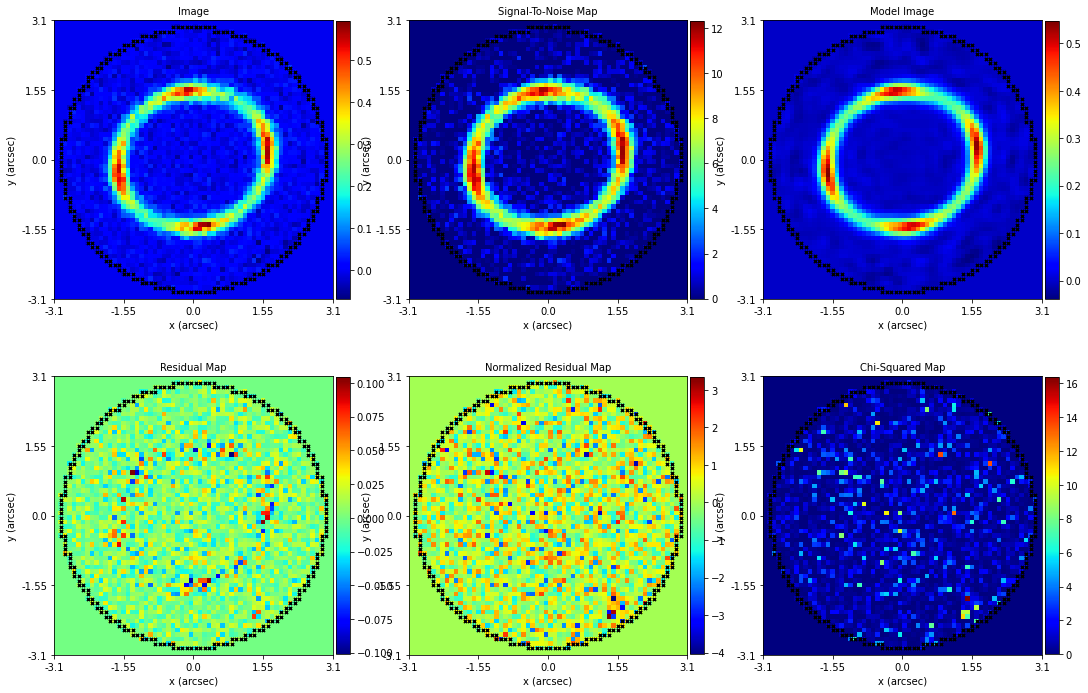

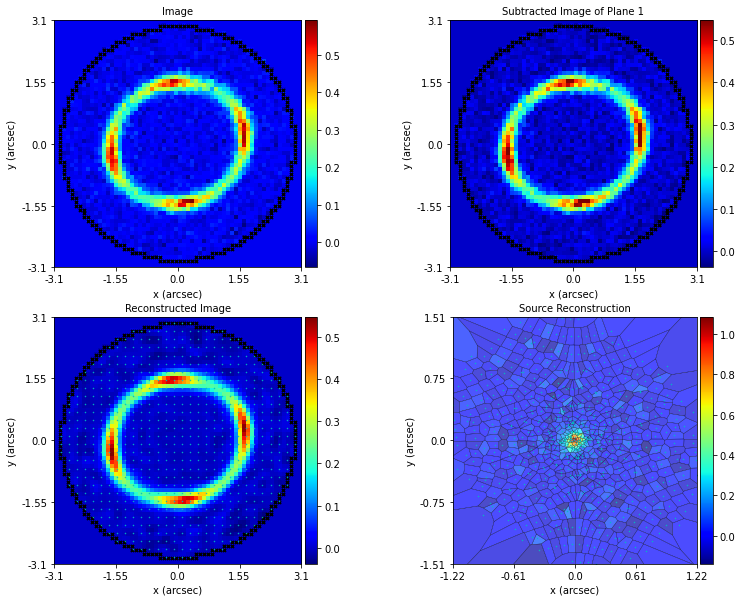

In [4]:
include_2d = aplt.Include2D(
    mask=True, mapper_data_pixelization_grid=True, mapper_source_pixelization_grid=True
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

__Hyper Image__

Finally, we can use this fit to set up our hyper-image. This hyper-image is not perfect, because there are residuals in 
the central regions of the reconstructed source. However, it is *good enough** for us to use to adapt our pixelization
to the lensed source.

(The `binned` attribute below ensures our hyper-image is at the native resolution of the imaging data, as opposed to a 
higher resolution sub-grid).

In [5]:
hyper_image = fit.model_image.binned.slim

__Adaption__

Now lets take a look at brightness based adaption in action! Below, we define a source-galaxy using our new 
`VoronoiBrightnessImage` pixelization and use this to fit the lens-data. 

We also attach the hyper_image to the source galaxy, via the inputs `hyper_model_image` and `hyper_galaxy_image`. In
tutorial 4, we will explain why the hyper image is input twice as two seperate inputs, for now just ignore this!

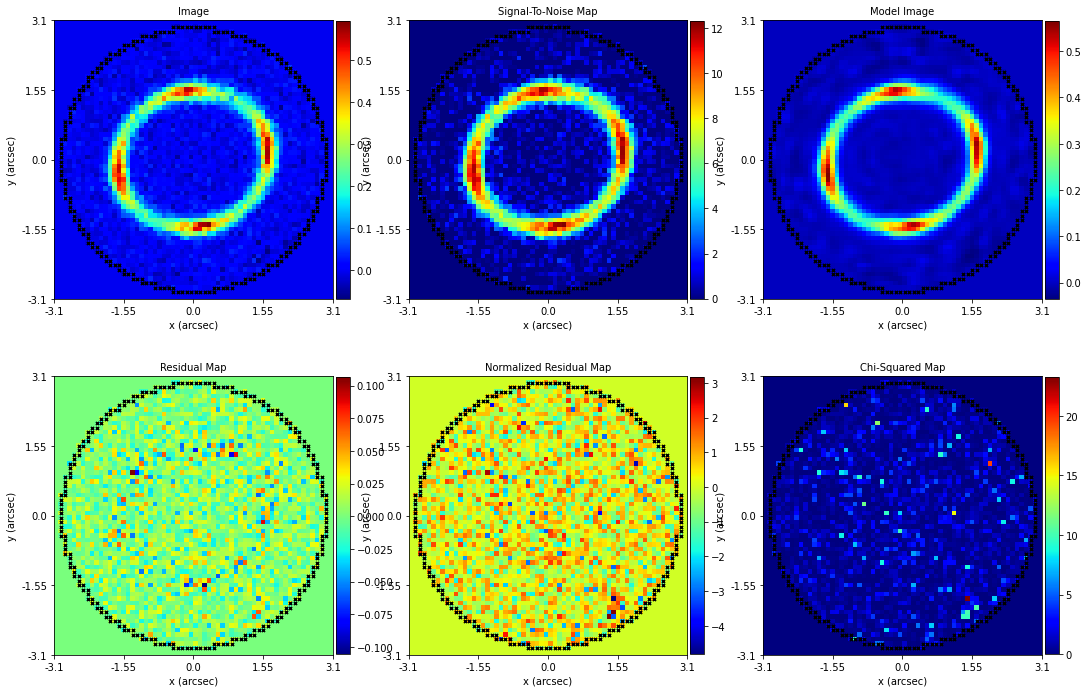

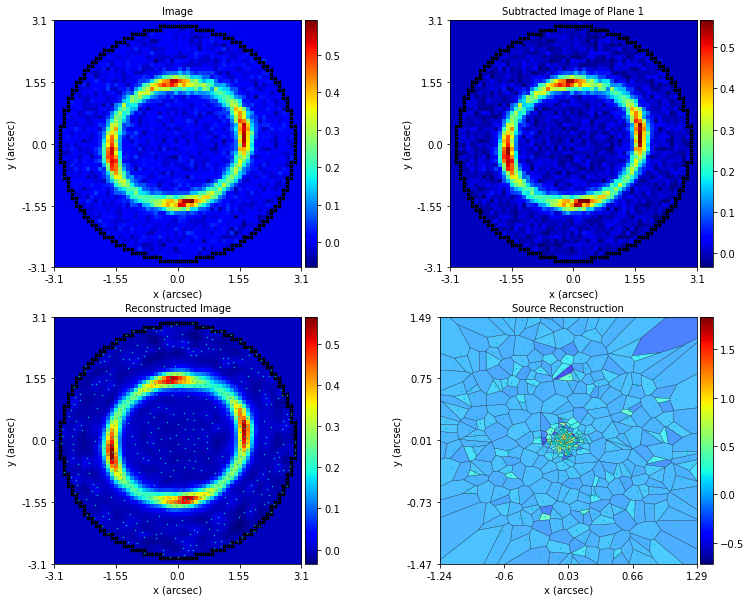

In [6]:
source_galaxy_brightness = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=10.0
    ),
    regularization=al.reg.Constant(coefficient=0.5),
    hyper_model_image=hyper_image,
    hyper_galaxy_image=hyper_image,
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy_brightness])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

Would you look at that! Our reconstruction of the image no longer has residuals! By congregating more source 
pixels in the brightest regions of the source reconstruction we get a better fit. Furthermore, we can check that 
this provides an increase in Bayesian log evidence, noting that the log evidence of the compact source when using a 
`VoronoiMagnification` pixelization was 4216:

In [7]:
print("Evidence using magnification based pixelization. ", 4216)
print("Evidence using brightness based pixelization. ", fit.log_evidence)

Evidence using magnification based pixelization.  4216
Evidence using brightness based pixelization.  5660.744405470697


It increases! By over 1000, which, for a Bayesian evidence, is pretty damn large! By any measure, this 
pixelization is a huge success. It turns out that we should have been adapting to the source's brightness all along! 
In doing so, we will *always* reconstruct the detailed structure of the source's brightest regions with a sufficiently 
high resolution. Hurrah!

So, we are now able to adapt the pixelization to the morphology of the lensed source galaxy. To my knowledge, this
is the *best* approach one can take in lens modeling. Its more tricky to implement and introduces additional non-linear 
parameters. But the pay-off is more than worth it, as we fit our data better and use fewer source pixels to reconstruct
the source, given that we 'waste' pixels reconstructing regions of the source-plane where there is no signal.

__KMeans__

So how does the `hyper_image` adapt the pixelization to the source's brightness? It uses a 'weighted KMeans clustering 
algorithm', which is a standard algorithm for partioning data in statistics.

In simple terms, this algorithm works as follows:

 1) Give the KMeans algorithm a set of weighted data (e.g. these weights are determined from the hyper-image).
    
 2) For a given number of K-clusters, this algorithm finds a set of $(y,x)$ coordinates that equally partition the 
 weighted data-set. Wherever the data has higher weighting, more clusters congregate and visa versa.
    
 3) The returned $(y,x)$ 'clusters' then make up our source-pixel centres, where the brightest (e.g. higher weighted 
 regions of the hyper-image) will have more clusters! We can then trace these coordinates to the source-plane to define 
 our source-pixel pixelization.

This is a fairly simplistic description of a KMeans algorithm. Feel free to check out the chains below for a more 
in-depth view:

 https://en.wikipedia.org/wiki/K-means_clustering
 https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


__Weight Map__

We now have a sense of how our `VoronoiBrightnessImage` pixelization is computed. Now, lets look at how we create the 
weighted data the KMeans algorithm uses.

This image, called the `cluster_weight_map` is generated using the `weight_floor` and `weight_power` parameters of 
the `VoronoiBrightnessImage` object. The cluster weight map is generated following 4 steps:

 1) Increase all values of the hyper-image that are < 0.02 to 0.02. This is necessary because negative values and 
 zeros break the KMeans clustering algorithm.
    
 2) Divide all values of this image by its maximum value, such that the hyper-image now only contains values between 
 0.0 and 1.0 (where the values of 1.0 are the maximum values of the hyper-image).
    
 3) Add the weight_floor to all values (a weight_floor of 0.0 therefore does not change the cluster weight map).
    
 4) Raise all values to the power of weight_power (a weight_power of 1.0 therefore does not change the cluster 
 weight map, whereas a value of 0.0 means all values 1.0 and therefore weighted equally).

Lets look at this in action. we'll inspect 3 cluster_weight_maps, using a weight_power of 0.0, 5.0 and 10.0, 
setting the `weight_floor` to 0.0 such that it does not change the cluster weight map.

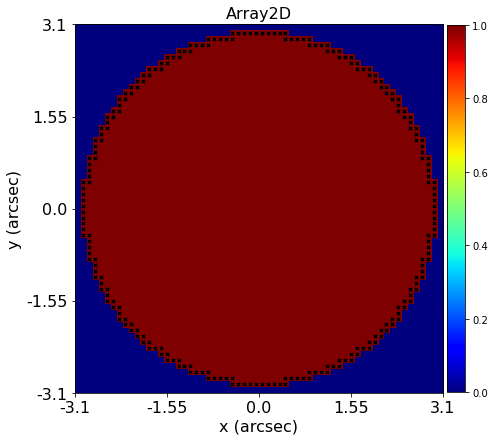

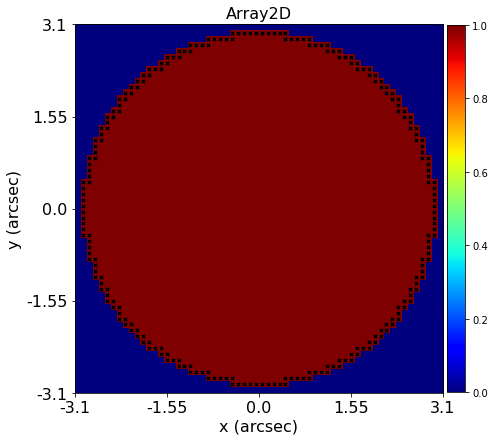

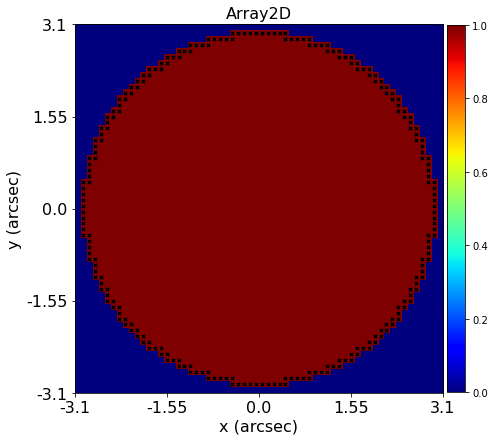

In [8]:
source_weight_power_0 = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=0.0
    ),
    regularization=al.reg.Constant(coefficient=1.0),
    hyper_model_image=hyper_image,
    hyper_galaxy_image=hyper_image,
)

cluster_weight_power_0 = source_weight_power_0.pixelization.weight_map_from_hyper_image(
    hyper_image=source_weight_power_0.hyper_galaxy_image
)

array_plotter = aplt.Array2DPlotter(
    array=cluster_weight_power_0, visuals_2d=aplt.Visuals2D(mask=mask)
)
array_plotter.figure_2d()

source_weight_power_5 = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=5.0
    ),
    regularization=al.reg.Constant(coefficient=1.0),
    hyper_model_image=hyper_image,
    hyper_galaxy_image=hyper_image,
)

cluster_weight_power_5 = source_weight_power_5.pixelization.weight_map_from_hyper_image(
    hyper_image=source_weight_power_5.hyper_galaxy_image
)

array_plotter = aplt.Array2DPlotter(
    array=cluster_weight_power_0, visuals_2d=aplt.Visuals2D(mask=mask)
)
array_plotter.figure_2d()

source_weight_power_10 = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=10.0
    ),
    regularization=al.reg.Constant(coefficient=1.0),
    hyper_model_image=hyper_image,
    hyper_galaxy_image=hyper_image,
)

cluster_weight_power_10 = source_weight_power_10.pixelization.weight_map_from_hyper_image(
    hyper_image=source_weight_power_10.hyper_galaxy_image
)

array_plotter = aplt.Array2DPlotter(
    array=cluster_weight_power_0, visuals_2d=aplt.Visuals2D(mask=mask)
)
array_plotter.figure_2d()

When we increase the weight-power the brightest regions of the hyper-image become weighted higher relative to the 
fainter regions. This means that the KMeans algorithm will adapt its pixelization to the brightest regions of the 
source.

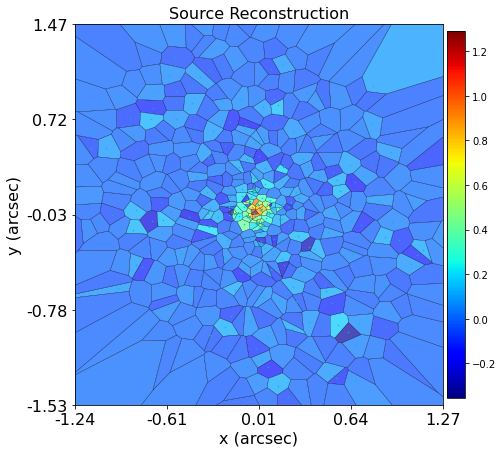

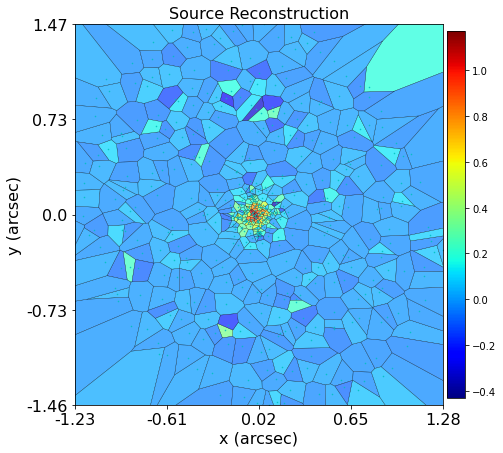

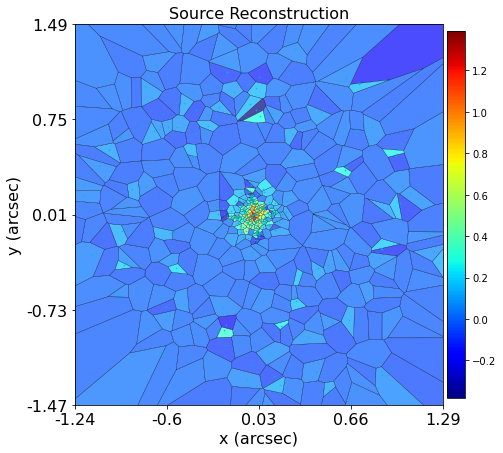

In [9]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_weight_power_0])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_weight_power_5])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_weight_power_10])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

So, what does the `weight_floor` do? Increasing the weight-power congregates pixels around the source. However, there 
is a risk that by congregating too many source pixels in its brightest regions we lose resolution further out, where 
the source is bright, but not its brightest!

The `noise-floor` allows these regions to maintain a higher weighting whilst the `noise_power` increases. This means 
that the pixelization can fully adapt to the source's brightest and faintest regions simultaneously.

Lets look at once example:

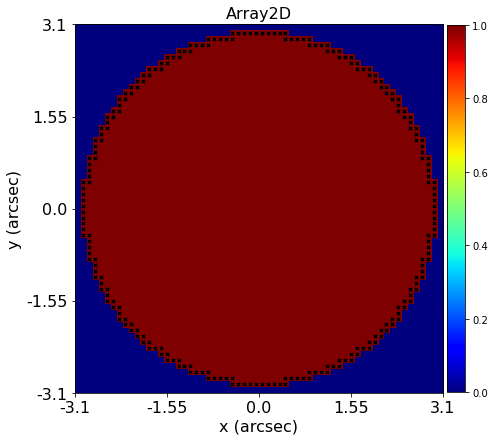

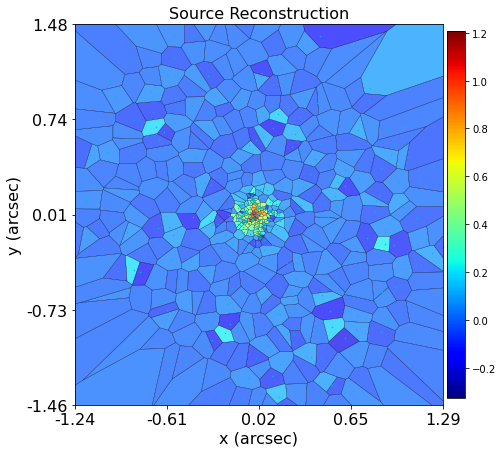

In [10]:
source_weight_floor = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.5, weight_power=10.0
    ),
    regularization=al.reg.Constant(coefficient=1.0),
    hyper_galaxy_image=hyper_image,
)

cluster_weight_floor = source_weight_floor.pixelization.weight_map_from_hyper_image(
    hyper_image=source_weight_floor.hyper_galaxy_image
)

array_plotter = aplt.Array2DPlotter(
    array=cluster_weight_power_0, visuals_2d=aplt.Visuals2D(mask=mask)
)
array_plotter.figure_2d()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_weight_floor])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.figures_2d_of_planes(plane_image=True, plane_index=1)

__Wrap Up__

To end, lets think about the Bayesian evidence, which we saw now goes to significantly higher values than for a 
magnification-based grid. At this point, it might be worth reminding yourself how the Bayesian evidence works by 
going back to description in this chapters `introduction` text file.

So, why do you think why adapting to the source's brightness increases the log evidence?

It is because by adapting to the source's morphology we can now access solutions that fit the data really well 
(e.g. to the Gaussian noise-limit) but use significantly fewer source-pixels than before. For instance, a typical 
magnification based grid uses resolutions of 40 x 40, or 1600 pixels. In contrast, a morphology based pixelization 
typically uses just 300-800 pixels (depending on the source itself). Clearly, the easiest way to make our source 
solution simpler is to use fewer pixels overall!

This provides a second benefit. If the best solutions in our fit want to use the fewest source-pixels possible and 
**PyAutoLens** can now access those solutions, this means that hyper-mode will run much faster than the magnification 
based grid! Put simply, fewer source-pixels means lower computational overheads. YAY!

Tutorial 2 done, next up, adaptive regularization!